# IMDB Sentiment Analysis with LSTM (TensorFlow/Keras)

This notebook builds a **memory-efficient LSTM-based sentiment classifier** for IMDB movie reviews.

**Key specs:**
- **Dataset:** IMDB movie reviews (10,000 training samples subset)
- **Model:** Embedding → LSTM → Dense (sigmoid)
- **Constraints:** Runs on CPU with <4GB RAM, no GPU required
- **Output:** Trained model + Streamlit inference app

## 1. Install and Import Dependencies

In [1]:
%pip install tensorflow matplotlib streamlit --quiet

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")

2026-02-20 22:30:37.980952: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-20 22:30:38.008802: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-20 22:30:38.875438: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


TensorFlow version: 2.20.0
NumPy version: 2.4.2


## 2. Configure TensorFlow for Low-Memory CPU Execution

Force TensorFlow to use CPU only and suppress unnecessary warnings. This keeps memory usage well under 4GB.

In [2]:
# Force CPU-only execution
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # Suppress INFO/WARNING logs

# If GPUs are somehow visible, enable memory growth to avoid full allocation
try:
    gpus = tf.config.list_physical_devices("GPU")
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Found {len(gpus)} GPU(s) — enabled memory growth")
    else:
        print("No GPU detected — running on CPU (as intended)")
except RuntimeError as e:
    print(f"GPU config error (safe to ignore): {e}")

# Verify device
print(f"Available devices: {[d.name for d in tf.config.list_logical_devices()]}")

No GPU detected — running on CPU (as intended)
Available devices: ['/device:CPU:0']


## 3. Load and Subset the IMDB Dataset

Load IMDB with a vocabulary cap of 10,000 words. Use only the **first 10,000 training** and **first 2,000 test** samples to keep memory usage minimal.

In [3]:
# Hyperparameters
VOCAB_SIZE = 10_000
MAX_LENGTH = 200
EMBEDDING_DIM = 64
LSTM_UNITS = 64
TRAIN_SUBSET = 10_000
TEST_SUBSET = 2_000

# Load IMDB dataset (only keep top VOCAB_SIZE words)
print("Loading IMDB dataset...")
(x_train_full, y_train_full), (x_test_full, y_test_full) = tf.keras.datasets.imdb.load_data(
    num_words=VOCAB_SIZE
)

# Subset for low-memory usage
x_train = x_train_full[:TRAIN_SUBSET]
y_train = y_train_full[:TRAIN_SUBSET]
x_test = x_test_full[:TEST_SUBSET]
y_test = y_test_full[:TEST_SUBSET]

# Free full arrays
del x_train_full, y_train_full, x_test_full, y_test_full

print(f"Training samples: {len(x_train)}")
print(f"Test samples:     {len(x_test)}")
print(f"Vocabulary size:  {VOCAB_SIZE}")
print(f"Sample review length (before padding): {len(x_train[0])} tokens")
print(f"Label distribution (train): {np.bincount(y_train)}")

Loading IMDB dataset...
17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


/home/rei/Documents/Code Projects/imdb-sentiment-model/.venv/lib/python3.12/site-packages/numpy/lib/_format_impl.py:838: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  array = pickle.load(fp, **pickle_kwargs)


Training samples: 10000
Test samples:     2000
Vocabulary size:  10000
Sample review length (before padding): 218 tokens
Label distribution (train): [4947 5053]


## 4. Preprocess and Pad Sequences

Pad all sequences to a uniform length of 200 tokens. Shorter reviews get zero-padded; longer ones are truncated.

In [4]:
# Pad sequences to uniform length
print("Padding sequences...")
x_train_pad = pad_sequences(x_train, maxlen=MAX_LENGTH, padding="post", truncating="post")
x_test_pad = pad_sequences(x_test, maxlen=MAX_LENGTH, padding="post", truncating="post")

print(f"x_train_pad shape: {x_train_pad.shape}  (dtype: {x_train_pad.dtype})")
print(f"x_test_pad shape:  {x_test_pad.shape}")
print(f"Memory usage (train): ~{x_train_pad.nbytes / 1e6:.1f} MB")
print(f"\nSample padded sequence (first 20 tokens): {x_train_pad[0][:20]}")

Padding sequences...
x_train_pad shape: (10000, 200)  (dtype: int32)
x_test_pad shape:  (2000, 200)
Memory usage (train): ~8.0 MB

Sample padded sequence (first 20 tokens): [   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25]


## 5. Build the LSTM Sentiment Analysis Model

Architecture: **Embedding(10000, 64)** → **LSTM(64)** with dropout → **Dense(1, sigmoid)**

In [5]:
# Build Sequential LSTM model
model = Sequential([
    Embedding(
        input_dim=VOCAB_SIZE,
        output_dim=EMBEDDING_DIM,
        input_length=MAX_LENGTH,
        name="embedding"
    ),
    LSTM(
        LSTM_UNITS,
        dropout=0.2,
        recurrent_dropout=0.2,
        name="lstm"
    ),
    Dense(1, activation="sigmoid", name="output")
])

model.summary()

/home/rei/Documents/Code Projects/imdb-sentiment-model/.venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:100: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 6. Compile the Model

In [6]:
model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)
print("Model compiled: binary_crossentropy + Adam + accuracy")

Model compiled: binary_crossentropy + Adam + accuracy


## 7. Train the Model with EarlyStopping

Train for up to 5 epochs with 20% validation split. EarlyStopping will halt training early if validation loss stops improving (patience=2).

In [7]:
# EarlyStopping callback
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True,
    verbose=1
)

# Train the model
print("Starting training...")
history = model.fit(
    x_train_pad,
    y_train,
    epochs=5,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)
print("\nTraining complete!")

Starting training...
Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.5092 - loss: 0.6933 - val_accuracy: 0.5365 - val_loss: 0.6919
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.5906 - loss: 0.6787 - val_accuracy: 0.5585 - val_loss: 0.6729
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.6419 - loss: 0.5891 - val_accuracy: 0.5865 - val_loss: 0.6501
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.6852 - loss: 0.5195 - val_accuracy: 0.5875 - val_loss: 0.6879
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.6975 - loss: 0.4766 - val_accuracy: 0.5735 - val_loss: 0.7352
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 3.

Training complete!


## 8. Evaluate on Test Subset

In [8]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(x_test_pad, y_test, batch_size=32, verbose=1)
print(f"\n{'='*40}")
print(f"Test Loss:     {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.1f}%)")
print(f"{'='*40}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5960 - loss: 0.6562

Test Loss:     0.6562
Test Accuracy: 0.5960 (59.6%)


## 9. Plot Training Accuracy and Loss Curves

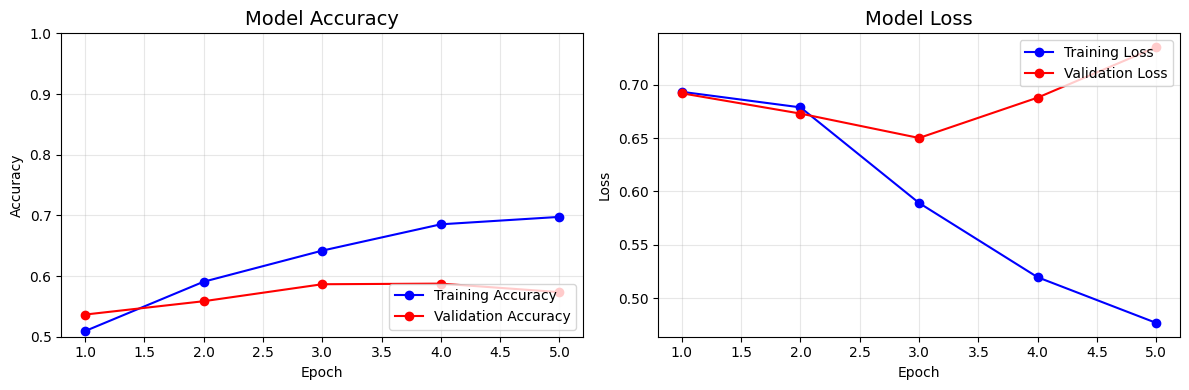

Saved training_curves.png


In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

epochs_range = range(1, len(history.history["accuracy"]) + 1)

# Accuracy subplot
ax1.plot(epochs_range, history.history["accuracy"], "b-o", label="Training Accuracy")
ax1.plot(epochs_range, history.history["val_accuracy"], "r-o", label="Validation Accuracy")
ax1.set_title("Model Accuracy", fontsize=14)
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
ax1.legend(loc="lower right")
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0.5, 1.0])

# Loss subplot
ax2.plot(epochs_range, history.history["loss"], "b-o", label="Training Loss")
ax2.plot(epochs_range, history.history["val_loss"], "r-o", label="Validation Loss")
ax2.set_title("Model Loss", fontsize=14)
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.legend(loc="upper right")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("training_curves.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved training_curves.png")

## 10. Inference Helper Function and Sample Predictions

Decode integer sequences back to text and predict sentiment for arbitrary review strings.

In [10]:
# Load word index for decoding/encoding
word_index = tf.keras.datasets.imdb.get_word_index()

# Offset indices: 0=padding, 1=start, 2=unknown, 3=unused
INDEX_OFFSET = 3
reverse_word_index = {v + INDEX_OFFSET: k for k, v in word_index.items()}
reverse_word_index[0] = "<PAD>"
reverse_word_index[1] = "<START>"
reverse_word_index[2] = "<UNK>"


def decode_review(encoded_sequence):
    """Convert integer-encoded review back to text."""
    return " ".join(reverse_word_index.get(i, "?") for i in encoded_sequence if i != 0)


def predict_sentiment(text, model=model):
    """Predict sentiment for a raw text string.
    
    Returns (label, confidence) where label is 'Positive' or 'Negative'.
    """
    # Tokenize: convert words to indices (with offset)
    words = text.lower().split()
    encoded = [word_index.get(w, 2 - INDEX_OFFSET) + INDEX_OFFSET for w in words]
    # Clamp to vocab range
    encoded = [min(i, VOCAB_SIZE - 1) for i in encoded]
    # Pad to MAX_LENGTH
    padded = pad_sequences([encoded], maxlen=MAX_LENGTH, padding="post", truncating="post")
    # Predict
    score = model.predict(padded, verbose=0)[0][0]
    label = "Positive" if score >= 0.5 else "Negative"
    confidence = score if score >= 0.5 else 1 - score
    return label, float(confidence)


# --- Demo: decode a training sample ---
print("=== Decoded Training Sample ===")
print(f"Label: {'Positive' if y_train[0] == 1 else 'Negative'}")
print(f"Review: {decode_review(x_train[0][:50])}...\n")

# --- Demo: predict on custom reviews ---
sample_reviews = [
    "This movie was absolutely fantastic! The acting was superb and the plot kept me on the edge of my seat.",
    "Terrible waste of time. The story made no sense and the acting was wooden and boring.",
    "It was okay, nothing special but not bad either. Some decent moments here and there.",
]

print("=== Sample Predictions ===")
for review in sample_reviews:
    label, conf = predict_sentiment(review)
    print(f"\n> \"{review[:80]}...\"")
    print(f"  Prediction: {label} (confidence: {conf:.2%})")

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step
=== Decoded Training Sample ===
Label: Positive
Review: <START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved...

=== Sample Predictions ===

> "This movie was absolutely fantastic! The acting was superb and the plot kept me ..."
  Prediction: Negative (confidence: 51.38%)

> "Terrible waste of time. The story made no sense and the acting was wooden and bo..."
  Prediction: Negative (confidence: 51.38%)

> "It was okay, nothing special but not bad either. Some decent moments here and th..."
  Prediction: Negative (confidence: 51.38%)


## 11. Save Model & Generate Streamlit App

Save the trained model and create a standalone Streamlit app for interactive inference.

In [11]:
# Save the trained model
MODEL_PATH = "imdb_lstm_model.keras"
model.save(MODEL_PATH)
print(f"Model saved to: {MODEL_PATH}")
print(f"Model file size: {os.path.getsize(MODEL_PATH) / 1e6:.2f} MB")

Model saved to: imdb_lstm_model.keras
Model file size: 8.10 MB


In [12]:
%%writefile streamlit_app.py
"""
IMDB Sentiment Analysis — Streamlit Inference App
Run with:  streamlit run streamlit_app.py
"""

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import streamlit as st
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# ── Constants ──────────────────────────────────────────────
VOCAB_SIZE = 10_000
MAX_LENGTH = 200
MODEL_PATH = "imdb_lstm_model.keras"
INDEX_OFFSET = 3


@st.cache_resource
def load_model():
    """Load the trained LSTM model (cached across reruns)."""
    return tf.keras.models.load_model(MODEL_PATH)


@st.cache_resource
def load_word_index():
    """Load and cache the IMDB word index."""
    return tf.keras.datasets.imdb.get_word_index()


def predict_sentiment(text: str, model, word_index: dict) -> tuple[str, float]:
    """Predict sentiment for a raw text string."""
    words = text.lower().split()
    encoded = [word_index.get(w, 2 - INDEX_OFFSET) + INDEX_OFFSET for w in words]
    encoded = [min(i, VOCAB_SIZE - 1) for i in encoded]
    padded = pad_sequences([encoded], maxlen=MAX_LENGTH, padding="post", truncating="post")
    score = float(model.predict(padded, verbose=0)[0][0])
    label = "Positive" if score >= 0.5 else "Negative"
    confidence = score if score >= 0.5 else 1 - score
    return label, confidence


# ── Streamlit UI ───────────────────────────────────────────
st.set_page_config(page_title="IMDB Sentiment Analyzer", page_icon="🎬", layout="centered")

st.title("🎬 IMDB Sentiment Analyzer")
st.markdown(
    "Enter a movie review below and the LSTM model will predict whether it's **positive** or **negative**."
)

# Load resources
model = load_model()
word_index = load_word_index()

# Input
review_text = st.text_area(
    "Movie Review",
    height=150,
    placeholder="Type or paste a movie review here...",
)

col1, col2 = st.columns([1, 4])
with col1:
    predict_btn = st.button("🔍 Predict", type="primary", use_container_width=True)

if predict_btn and review_text.strip():
    with st.spinner("Analyzing sentiment..."):
        label, confidence = predict_sentiment(review_text, model, word_index)

    # Display result with color coding
    if label == "Positive":
        st.success(f"**{label}** — Confidence: {confidence:.1%}")
        st.balloons()
    else:
        st.error(f"**{label}** — Confidence: {confidence:.1%}")

    # Confidence bar
    st.progress(confidence, text=f"Confidence: {confidence:.1%}")

elif predict_btn:
    st.warning("Please enter a movie review first.")

# Sidebar info
with st.sidebar:
    st.header("ℹ️ About")
    st.markdown(
        """
        **Model:** LSTM (Long Short-Term Memory)  
        **Dataset:** IMDB Movie Reviews  
        **Vocab Size:** 10,000 words  
        **Max Length:** 200 tokens  
        **Architecture:** Embedding → LSTM(64) → Dense(sigmoid)
        """
    )
    st.markdown("---")
    st.markdown("Built with TensorFlow/Keras + Streamlit")

Writing streamlit_app.py


## ✅ Done!

**To run the Streamlit app:**

```bash
streamlit run streamlit_app.py
```

This will open an interactive web UI where you can type any movie review and get a real-time sentiment prediction from the trained LSTM model.